# Simulation setup for a FELTOR simulation
In this notebook we setup a simulation run for COMPASS with FELTOR.

We will go through the input parameters in the order as one typically should choose them. Details to each parameter are described in the documentation in `feltor/src/feltor/feltor.tex` (compile to pdf with `make doc`), so it may be helpful to open the documentation next to this notebook. The goal of this notebook is among others to mark the input parameters that are almost never changed in practise and those that are relevant to adapt for the situation at hand. We thus mark
`don't touch` any parameter that shouldn't be changed from the default unless you have a seriously good reason and know what you are doing.

This notebook uses the `pyfeltor` package https://github.com/feltor-dev/pyFeltor together with its `dg.geo`
extension as well as the `feltorutilities` package (this package) and the `magneticfilelddb` package from https://github.com/feltor-dev/magneticfielddb


In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import json
import scipy
from pyfeltor import dg
import feltorutilities as fp
import magneticfielddb as magdb
import simplesimdb as simplesim
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2e' % x)

## Magnetic field
We already generated magnetic field parameters in the `polynomial_fit.ipynb` notebook.

In [2]:
# Select your file 
file = "compass-1X"
magparams = magdb.select("COMPASS/compass_1X.json")
mag = dg.geo.createMagneticField(magparams)


## Simulation box
The first task after the magnetic field is fixed is to choose an appropriate simulation box. This is done in connection with a choice for the wall and the sheath boundary regions. The resolution of the grid can only be chosen once the physical parameters are set.

The choice for the box, wall and sheath is typically an iterative process...

In [3]:
# First define some plotting routines
def plot_lvls( ax, R, Z, rhop, lvls):
    # always draw separatrix
    im = ax.contour( R, Z, rhop, levels=[1], linewidths=1,colors='k')
    try: 
        for lvl in lvls:
            if lvl < 1:
                im = ax.contour( R, Z, np.ma.masked_where(Z  >ZX,rhop), levels=[lvl], linewidths=1,colors='k')
            else:
                im = ax.contour( R, Z, rhop, levels=[lvl], linewidths=1,colors='k')
    except:
        if lvls < 1:
            im = ax.contour( R, Z, np.ma.masked_where(Z  >ZX,rhop), levels=[lvls], linewidths=1,colors='k')
        else:
            im = ax.contour( R, Z, rhop, levels=[lvls], linewidths=1,colors='k')
    


def plot_psip( ax, R, Z, psip):

    im = ax.pcolormesh(R,Z,psip,cmap="gist_ncar", shading ="gouraud")
    fig.colorbar(im, ax=ax)
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.grid(which="both")
    ax.yaxis.grid(which="both")    
    ax.set_title( r"$\psi_p$")
    ax.set_xlabel( "R [m]")
    ax.set_ylabel( "Z [m]")
    ax.axis("scaled")
    
def plot_trans( ax, R, Z, trans, sheath):
    
    plot = trans
    plot = np.ma.masked_array( plot, plot==0)
    im = ax.pcolormesh(R,Z, plot,
                          cmap="ocean_r", shading="gouraud") 
    fig.colorbar(im, ax=ax)

    plot = sheath
    plot = np.ma.masked_array( plot, plot==0)
    im = ax.pcolormesh(R, Z, plot,
                     vmin=-1, vmax=1, cmap="bwr", shading="gouraud") 

    ax.axis("scaled")

    #     ax[rr][cc].xaxis.grid(which="both")
    #     ax[rr][cc].yaxis.grid(which="both")  
    #     ax[rr][cc].xaxis.set_minor_locator(tck.AutoMinorLocator())
    #     ax[rr][cc].yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_title( "Magnetic Transition")
    ax.set_xlabel( "R [m]")
    ax.set_ylabel( "Z [m]") 



In [4]:
# Let's start by setting up some default parameters
scaleR = [1,1]
scaleZ = [1,1]
wall = {
    "type" : "heaviside",
    "boundary" : 1.1,
    "alpha" : 0.2
}
sheath = {
    "boundary" : 3/32,
    "alpha" : 2/32
}

In [5]:
def generate_fields( scaleR, scaleZ, wall, sheath, res = (80,80)):
    # from the documentation we know that this is how the box is chosen
    x0 = [mag.R0() - scaleR[0]*mag.params().a(), -scaleZ[0]*mag.params().a()]
    x1 = [mag.R0() + scaleR[1]*mag.params().a(), +scaleZ[1]*mag.params().a()]
    grid = dg.Grid( x0, x1, [1,1],res)
    sheath_walls =dg.Grid( x0, x1, [1,1],res)
    wall_f = dg.geo.CylindricalFunctor()
    trans_f = dg.geo.CylindricalFunctor()
    sheath_f = dg.geo.CylindricalFunctor()
    modmag = dg.geo.createModifiedField( magparams, wall, wall_f, trans_f)
    dg.geo.createSheathRegion( sheath, mag, wall_f, sheath_walls, sheath_f )

    R = dg.evaluate( lambda R,Z:  R, grid).reshape(grid.shape)
    Z = dg.evaluate( lambda R,Z:  Z, grid).reshape(grid.shape)
    psip = dg.evaluate( mag.psip(), grid).reshape(grid.shape)
    rhop = dg.evaluate( dg.geo.RhoP(mag), grid).reshape(grid.shape)
    trans = dg.evaluate( trans_f, grid).reshape(grid.shape)
    sheath_p = dg.evaluate( sheath_f, grid).reshape(grid.shape)
    return (R,Z,psip,rhop,trans,sheath_p, grid, sheath_walls)

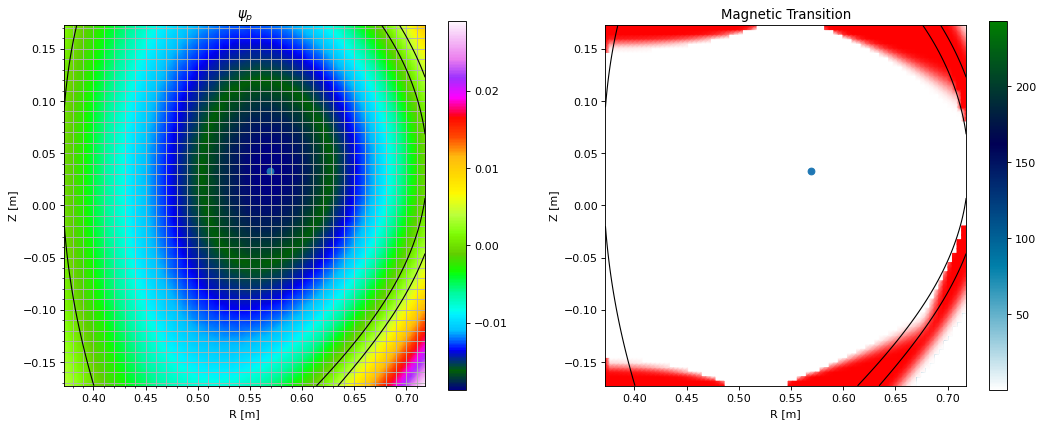

In [6]:

frows = 1
fcols = 2
(point,RO,ZO) = dg.geo.findOpoint(mag.get_psip(),mag.R0(), 0)
(RX,ZX) = dg.geo.findXpoint(mag.get_psip(),mag.R0()-1.1*mag.params().triangularity()*mag.params().a(),
                            -1.1*mag.params().elongation()*mag.params().a())
(R,Z,psip,rhop,trans,sheath_p,grid,sheath_walls) = generate_fields( scaleR, scaleZ, wall, sheath, (80,80))
grid_ratio = grid.lx()[1]/grid.lx()[0]
fig,axs=plt.subplots(frows,fcols,figsize=(fcols*8,frows*6*grid_ratio),dpi= 80, facecolor='w', edgecolor='k')
ax = axs[0]
plot_lvls( ax, R, Z, rhop, wall["boundary"])
plot_psip(ax, R, Z, psip)
ax.scatter( RO,ZO)
ax.scatter( RX,ZX)
ax = axs[1]  
plot_lvls( ax, R, Z, rhop, wall["boundary"])
plot_trans(ax, R, Z, trans, sheath_p)
ax.scatter( RO,ZO)
ax.scatter( RX,ZX)

plt.show()

As we can see the box does not fully contain the closed fieldline region or the X-point and the sheath region is seriously confused. 
- The magnetic transition needs to be entirely inside the box except for where the divertor is supposed to be
- create a wall region such that fieldlines intersect the wall only in the sheath region and structures can be dampened away
- the sheath region should be as broad as possible
- create a sheath region with distinct in- and outflow (sheath in and outflow should not be connected)


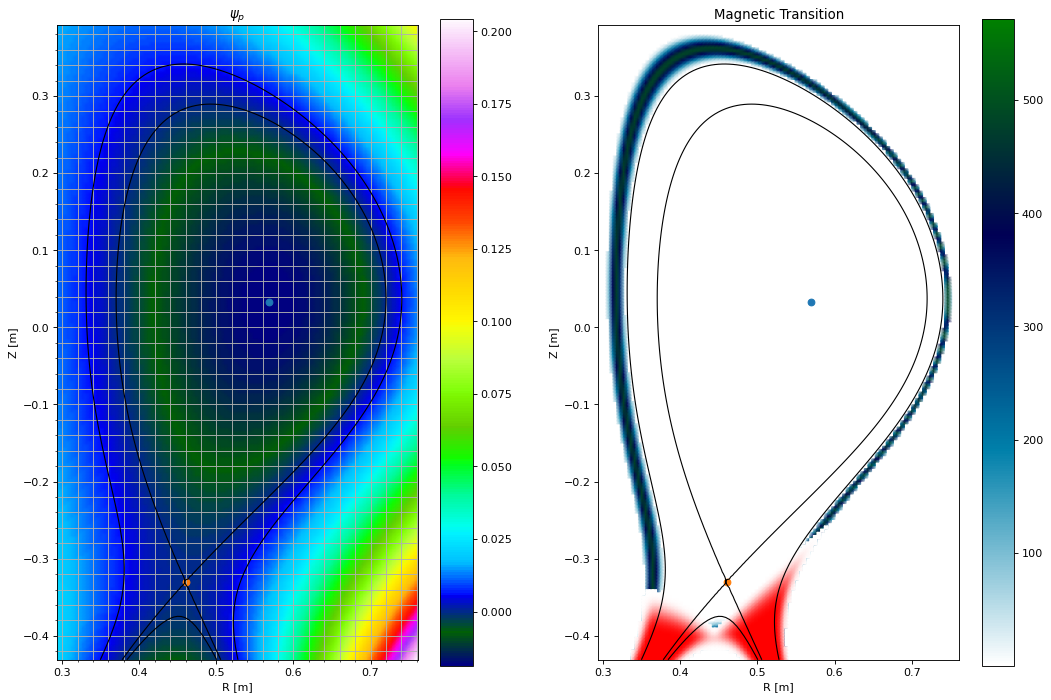

In [7]:
# Let us calibrate the wall (typically go through this cell multiple times)

scaleR = [1.45,1.25]
scaleZ = [2.475,2.25]
wall = {
    "type" : "sol_pfr",
    "boundary" : [1.15,0.97],
    "alpha" : [0.10,0.10]
}

sheath = {
    "boundary" : 7/32,  # Total width of sheath in units of 2Pi
    "alpha" : 7/32 - 2/32 # Transition width of sheath in units of 2Pi
}
lvls = wall["boundary"][::-1]
lvls.insert(1, 1)

(R,Z,psip,rhop,trans,sheath_p,grid,sheath_walls) = generate_fields( scaleR, scaleZ, wall, sheath, (100,200))
grid_ratio = grid.lx()[1]/grid.lx()[0]
fig,axs=plt.subplots(frows,fcols,figsize=(fcols*8,frows*6*grid_ratio),dpi= 80, facecolor='w', edgecolor='k')
ax = axs[0]
plot_lvls( ax, R, Z, rhop, wall["boundary"])
plot_psip(ax, R, Z, psip)
ax.scatter( RO,ZO)
ax.scatter( RX,ZX)
ax = axs[1]  
plot_lvls( ax, R, Z, rhop, wall["boundary"])
plot_trans(ax, R, Z, trans, sheath_p)
ax.scatter( RO,ZO)
ax.scatter( RX,ZX)
plt.show()


We will return to the grid, wall and sheath parameters once we choose physical parameters and set up initial and boundary conditions

## Initital conditions, boundary conditions and sources

In order to calibrate the initial condition we need to invoke the feltor code in calibration mode. 

In [8]:
inputfile = fp.load_calibration_default()

In [9]:
inputfile["magnetic_field"]["params"] = magparams
# First set the box, wall and sheath calibration parameters chosen above
inputfile["grid"] = {"Nx" : 80, "Ny" : 160, "Nz": 1, "n": 1,
                     "scaleR" : scaleR, "scaleZ" : scaleZ}

# First we setup the wall and sheath that we calibrated above

minne = 0.2 # See text below
inputfile["boundary"] = {
    "wall" : 
    {
        "type" : wall["type"],
        "boundary" : wall["boundary"],
        "alpha" : wall["alpha"],
        "penalization" : 1e-2, # don't touch unless it influences timestep
        "modify-B" : True, #don't touch
        "penalize-rhs" : True, # don't touch
        "nwall" : minne,
        "uwall" : 0, # don't touch
    },
    "sheath" :
    {
        "type" : "insulating",
        "boundary" : sheath["boundary"],
        "alpha" : sheath["alpha"],
        "penalization" : 5.0, # don't touch unless it influences timestep
        "penalize-rhs" : True, # don't touch
        "coordinate" : "s", #don't touch
        "max_angle" : 4 # don't touch
    },
    "bc" :
    {
        "density" : ["NEU", "NEU"],
        "velocity": ["NEU", "NEU"],
        "potential":["DIR", "DIR"],
        "aparallel":["NEU", "NEU"]
    }
}


### The minne parameter
The "minne" parameter was introduced to prevent too small densities in the SOL, which would lead to an unbearably high CFL condition due to the term 
$$ 
\partial_t U_\parallel \simeq \nu_\parallel \frac{1}{N} \Delta_\parallel U_\parallel
$$
However, the minne parameter also prevents holes from forming if the density profile in the SOL becomes too small, such that "minne" also should not be chosen too large. Something like $0.1$ or $0.2$ seem to be good starting values.

The minne value also sets the "wall": "nwall" boundary condition and from there, the initial density background profile.

The only other two parameters that you may want to revisit after running test simulations are the wall and sheath penalization parameters since these may influence the timestep or dampen instabilities. Leave them as default and only come back if nothing else works though.

In [10]:
# For the initial profile we choose a Psi_p aligned profile with max and SOL density from experiment

inputfile["init"] = {
    "type" : "fields", 
    "density" : 
    {
        "type" : "ne",
        "ntilde" :
        { # usually no need to touch
            "type" : "turbulence", 
            "amplitude" : 1e-4,
            "revolutions" : 1, 
            "parallel" : "gaussian",
            "sigma_z" : 0.5,
        },
        "profile":
        {
            "type" : "aligned", 
            "npeak" : 8.5,
            "nsep" : 1.0,
            "background" : minne
        },
        "damping":
        {
            "type" : "alignedPFR",
            "boundary" : wall["boundary"],
            "alpha" : [0.1,0.03] # trim: must not be too small else Laplacian n_e explodes
        }
    },
    "velocity" :
    {
        "type" : "ui",
        "profile" : "linear_cs" # fulfills sheath boundary conditions
    },
    "potential" : {  # don't touch
        "type" : "zero_pol"
    },
    "aparallel" : { # don't touch
        "type" : "zero"
    }
}

In [11]:
# We choose to fix the influx of particles for our simulations:
inputfile["source"] ={
    "minne" : minne,
    "minrate" : 1.0,
    "minalpha" : 0.05,
    "type" : "influx",
    "rate": 1e-4,
    "profile" : {
        "type": "aligned",
        "npeak" : 1.0,
        "nsep" : 1.0/8.5,
        "background" : 0.0,
    },
    "ntilde" : {"type" : "zero"},
    "damping" : {
        "type" : "alignedX",
        "alpha" : 0.2,
        "boundary" : 0.55
    }
}
rep = simplesim.Repeater( "./feltor.sh", "temp.json", "temp.nc")
rep.run( inputfile, error='display') # the sheath integrating may take a minute

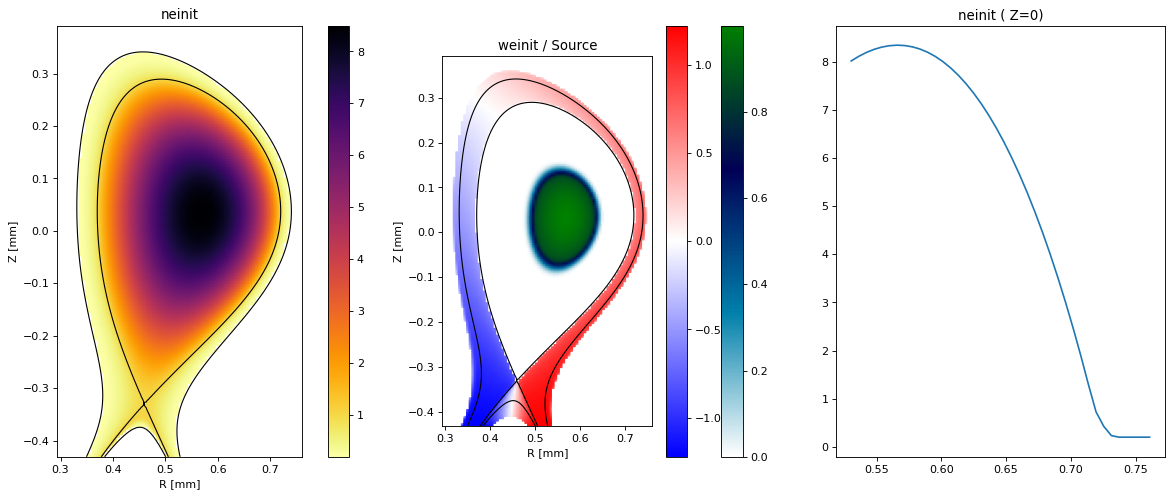

In [12]:
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
x = ncin["x"][:]
y = ncin["y"][:]
frows = 1
fcols = 3
fig,axs=plt.subplots(frows,fcols,figsize=(fcols*6,frows*4*grid_ratio),dpi= 80, facecolor='w', edgecolor='k')
ax = axs[0]
name = "neinit"
plot = ncin[name][:,:]
plot = np.ma.masked_array( plot, plot==inputfile["init"]["density"]["profile"]["background"])
im = ax.pcolormesh(x, y, plot,
                      cmap="inferno_r", shading="gouraud") 
fig.colorbar(im, ax=ax)
plot_lvls(ax, R, Z, rhop,wall["boundary"])

ax.set_title( name)

ax = axs[1]
name = "Source"
plot = ncin[name][:,:]
plot = np.ma.masked_array( plot, plot==0)
im = ax.pcolormesh(x, y, plot, cmap="ocean_r", shading="gouraud") 
fig.colorbar(im, ax=ax)
name = "weinit"
plot = ncin[name][:,:]
plot = np.ma.masked_array( plot, plot==0)
im = ax.pcolormesh(x, y, plot, cmap="bwr", shading="gouraud") 
fig.colorbar(im, ax=ax)
plot_lvls(ax, R, Z, rhop,wall["boundary"])
ax.set_title( "weinit / Source")

for ax in [axs[0], axs[1]]:
    ax.axis("scaled")
    ax.set_xlabel( "R [mm]")
    ax.set_ylabel( "Z [mm]")   
ax = axs[2]
Z0idx = np.argmin( np.abs( y-0))
ax.plot( x[x.size//2:], ncin["neinit"][Z0idx, x.size//2 : ])
ax.set_title( "neinit ( Z=0)")
plt.show()

In [13]:
# A routine to find the separatrix for given Z value
def find_sepR( mag, Rstart, Z0):
    root = scipy.optimize.newton( mag.psip(), Rstart, mag.psipR(), args=(ZO,))
    return root

## Probes [Optional]
Probes (or synthetic diagnostics in general) are set up in Feltor by proving 3 flat 1d arrays "R", "Z", "P" in the input file that contain the coordinates of the measurement locations.

As part of setting up probes, we integrate the magnetic field-lines
$$
\frac{ d R}{d \varphi} = \frac{B^R}{B^\varphi} \quad \frac{d Z}{d \varphi} = \frac{B^Z}{B^\varphi}
$$

In [14]:
BR = dg.geo.BFieldR(mag)
BZ = dg.geo.BFieldZ(mag)
BP = dg.geo.BFieldP(mag)
# In y we combine R,Z because solve_ivp wants a 1-d array (it is Fortran code after all...)
def rhs( t, y):
    return np.append( BR(y[:y.size//2], y[y.size//2:])/BP(y[:y.size//2], y[y.size//2:]),
                     BZ(y[:y.size//2], y[y.size//2:])/BP(y[:y.size//2], y[y.size//2:]))
    

def integrate_fieldlines( magparams, Rin, Zin, deltaPhi):
    if deltaPhi == 0 :
        return (Rin,Zin)
    sol = scipy.integrate.solve_ivp( rhs, (0,deltaPhi), np.append(Rin,Zin), method = "DOP853")
    return (sol.y[:Rin.size,-1], sol.y[Rin.size:,-1])

In [15]:
# set up a plotting routines for probes
def plot_probes(ax, R_probe, Z_probe, color, label):

    ax.axis("scaled")
    start, end = ax.get_xlim()
    #     ax.xaxis.set_ticks(np.arange(start, end, 20))
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.grid(which="both")
    ax.yaxis.grid(which="both")    
    ax.set_xlabel( "R [m]")
    ax.set_ylabel( "Z [m]")
    ax.scatter( R_probe, Z_probe , color = color, label = label)


For the COMPASS shot we want to have 4 diagnostics to investigate blob / filament physics: 
Since the magnetic field is symmetric we output measurements at all $\varphi$ positions we have (i.e. we make a meshgrid with $N_z=32$ planes):

In [16]:
phi_grid = dg.Grid( 0, 2*np.pi, 1, 32)
 # These are all of the toroidal angles in the simulation
phi_values = dg.evaluate( lambda x: x, phi_grid)

The format string will help parse the flat probe positions back into shaped arrays when doing diagnostics

1-3: Define a probe array situated at the outboard midplane. With one point on the separatrix, 7 points 2cm in the SOL and 3 in the edge, equi-distant. Then copy this array up and down 5mm in the Z-direction (the goal is to test whether the potential derivative with 5mm resolution matches the actual derivative). The original array (not the up-down arrays) should be integrated along the field-line to analyse blobs along the field-line. Finally, again meshgrid with 32 poloidal planes

4: Do the same (except the up-/down- probe arrays) at the inboard midplane 

In [17]:
num_pins = 21
width = 0.04 # width in m, with num_points we get 2 mm resolution in space
Rsep_outer = find_sepR( mag, RO+0.1, ZO)
Rsep_inner = find_sepR( mag, RO-0.1, ZO)
R_probe_inner = np.linspace( Rsep_inner - width/2, Rsep_inner + width/2, num_pins)
R_probe_outer = np.linspace( Rsep_outer - width/2, Rsep_outer + width/2, num_pins)
Z_probe_inner = np.full(num_pins, ZO)
Z_probe_outer = np.full(num_pins, ZO)


In [18]:
# Append the up-down probes to the divertor probe
(XPs,XRs) = np.meshgrid( phi_values, R_probe_outer,indexing='ij')
(XPs,XZs) = np.meshgrid( phi_values, Z_probe_outer+0.005,indexing='ij')
pos = 0
format = [{ "name" : "omp-plus", "pos" : (pos, pos+XRs.size), "shape" : XRs.shape}]
pos = pos + XRs.size

(p_,r_) = np.meshgrid( phi_values, R_probe_outer,indexing='ij')
(p_,z_) = np.meshgrid( phi_values, Z_probe_outer-0.005,indexing='ij')
XRs = np.append( XRs, r_)
XZs = np.append( XZs, z_)
XPs = np.append( XPs, p_)
format.append({ "name" : "omp-minus", "pos" : (pos, pos+r_.size), "shape" : r_.shape})
pos = pos + r_.size


In [19]:
# Integrate the omp and imp probe arrays
for _probe in ["omp", "imp"]:
    dphilist = [ -2*np.pi, -np.pi, -np.pi/2,-np.pi/4, 0, +np.pi/4, +np.pi/2, +np.pi]
    num_s = len( dphilist)
    RR_probe = np.zeros( (num_s,num_pins))
    ZZ_probe = np.zeros( (num_s,num_pins))
    PP_probe = np.zeros( (num_s,num_pins))
    i=0
    for dphi in dphilist:
        if _probe == "imp":
            Rout, Zout = integrate_fieldlines( magparams, R_probe_inner, Z_probe_inner, dphi)
        if _probe == "omp":
            Rout, Zout = integrate_fieldlines( magparams, R_probe_outer, Z_probe_outer, dphi)
        RR_probe[i,:] = Rout
        ZZ_probe[i,:] = Zout
        PP_probe[i,:] = np.full( num_pins, dphi)
        i = i+1
    
    # Now meshgrid with phi grid
    (p_,r_) = np.meshgrid( phi_values, RR_probe,indexing='ij')
    (p_,z_) = np.meshgrid( phi_values, ZZ_probe,indexing='ij')
    (p_,t_) = np.meshgrid( phi_values, PP_probe,indexing='ij')
    t_ = p_+t_ # for e.g. deltaPhi = 0 we need to put it at all phi grid points
    r_, z_, t_ = np.reshape( r_, (32,num_s,num_pins)), np.reshape( z_, (32,num_s,num_pins)), np.reshape( t_, (32,num_s,num_pins))
    XRs = np.append( XRs, r_)
    XZs = np.append( XZs, z_)
    XPs = np.append( XPs, t_)
    format.append({ "name" : _probe, "pos" : (pos, pos+r_.size), "shape" : r_.shape})
    pos = pos + r_.size

In [20]:
format

[{'name': 'omp-plus', 'pos': (0, 672), 'shape': (32, 21)},
 {'name': 'omp-minus', 'pos': (672, 1344), 'shape': (32, 21)},
 {'name': 'omp', 'pos': (1344, 6720), 'shape': (32, 8, 21)},
 {'name': 'imp', 'pos': (6720, 12096), 'shape': (32, 8, 21)}]

The format string serves to parse a flat array into named views. It is important that we can parse the array into views and do not need to copy, as copying may be expensive in post processing.

In [21]:

def reshape( array):
    named_array = dict()
    for f in format:
        named_array[f["name"]] = array[f["pos"][0]:f["pos"][1]].reshape(f["shape"])
    return named_array
def reshape_time( array):
    named_array = dict()
    for f in format:
        named_array[f["name"]] = array[:,f["pos"][0]:f["pos"][1]].reshape((array.shape[0],) + f["shape"])
    return named_array
    

In [22]:
# Test if reshape indeed creates a view rather than a copy
namedR, namedZ, namedP = reshape(XRs), reshape(XZs), reshape(XPs)
test_array_simulation = np.zeros( (5, XRs.size))
test_view = reshape_time( test_array_simulation)
test_view["omp-plus"][0,0,0] = -1243135125
test_array_simulation[0,0:3] # Hurray we have indeed a view

array([-1.24313512e+09,  0.00000000e+00,  0.00000000e+00])

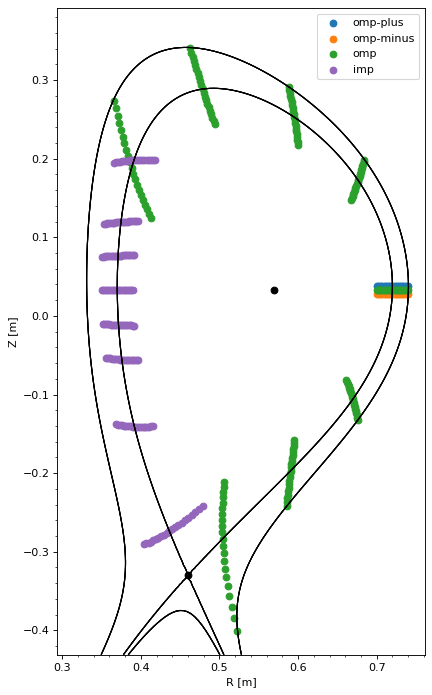

In [23]:
# Now plot the probes in different colors
frows = 1
fcols = 1
fig,axs=plt.subplots(frows,fcols,figsize=(fcols*8,frows*6*grid_ratio),dpi= 80, facecolor='w', edgecolor='k')
ax = axs
colors =[ 
'C0','C1','C2','C4','C5','C6','C7','C8','C9','k', 'w'    
]
i = 0
for f in format:
    name = f["name"]
    plot_lvls( ax, R, Z, rhop, wall["boundary"])
    plot_probes( ax,  namedR[name][0], namedZ[name][0], color = colors[i], label = name)
    i = i+1
ax.scatter( RO,ZO, color = 'k')
ax.scatter( RX,ZX, color = 'k')
plt.legend()
# plt.savefig( file+'-probes.png',bbox_inches="tight")
plt.show()

In [24]:
# Check varphi values of omp probes
namedP["imp"][1,:,0]%(2*np.pi)

# namedR["imp"][0,5,:]

array([0.29452431, 3.43611696, 5.00691329, 5.79231146, 0.29452431,
       1.07992247, 1.86532064, 3.43611696])

In [25]:
# In this study we do not use any probes ...
# # Now write to file
# output = {
#     "format" : format,
#     "coords-names" : ["R","Z","P"],
#     "R" : XRs.tolist(),
#     "Z" : XZs.tolist(),
#     "P" : XPs.tolist()
# }
# with open( file + "-probes.json", "w") as f:
#     json.dump( output, f,indent=1)

## All the rest

The remaining parameters are essential to pick because they directly influence the resulting file size and the simulation runtime:

### Physical parameters (Parameters in equations)

The first task for the physical parameters is to generate $\rho_s$ so that we can choose appropriate resolution for our domain

In [26]:
physicals=list()
for res in np.sort([3e-4,1e-4,3e-5,1e-5,3e-6,1e-6]):
    params = {"name" : "COMPASS",
    "beta" : 1e-4, "resistivity": res, #change both to change n_0
    "tau" : 1, "m_i" : fp.deuteron_mass, "R_0" : 545, "R": 0.545,
    "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32}
    physical = {"m_i" : fp.deuteron_mass,  "R": 0.545, "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32 }
    fp.numerical2physical( params, physical)
    physicals.append(physical)
physicals[0]

{'m_i': 3.3435837724e-27,
 'R': 0.545,
 'a': 0.175,
 'q': 2,
 'scaleR': 1.45,
 'Nz': 32,
 'T_e': 77.76088568677834,
 'n_0': 1.0365292381027862,
 'B_0': 1.2738887631949316,
 'T_i': 77.76088568677834}

In [27]:
rho_s = fp.parameters2quantity(physicals[0],"rho_s")
print( "Rho_s =", rho_s)
# convert R_0 to rho_s

print( "R in rho_s =", magparams["R_0"]/rho_s)



Rho_s = 0.000999999999999999
R in rho_s = 545.0000000000006


When choosing a grid resolution we want at least one point per $\rho_s$ if possible.
For reference the COMPASS simulations took $n=3$, $N_R = 192$ and $N_Z = 336$ and
ran on 16 GPUs on Marconi. The total number of grid points likely cannot be much higher. The $N_\varphi=32$ value may depend on the number of nodes/GPUs you have available on your cluster, e.g. 32 was chosen such that each GPU has 2 planes to compute. It is best not to MPI-parallelize the R and Z directions!


In [28]:
# Now we want to choose the Nx and Ny of our grid (we want at least one point per rhos)

lR = grid.lx()[0]/rho_s
lZ = grid.lx()[1]/rho_s
print( "Box width in rhos ", lR, lZ, "ratio", lZ/lR)
# Nx and Ny should be multiples 16
n = 3 # change only if you have a good reason
Nx = (int(lR/3/16)+3)*16
Ny = (int(lZ/3/16)+4)*16
print( "n, Nx, Ny", n, Nx, Ny)

Box width in rhos  472.50000000000045 826.8750000000009 ratio 1.7500000000000002
n, Nx, Ny 3 192 336


In [29]:
# Allright let's start with this
feltor_input_file=     {
    "magnetic_field" :
    {
        "curvmode" : "toroidal", # don't touch
        "input" : "file",
        "file" : file+'.json',
        "scale" : 1./rho_s
    },
    "grid" :
    {
        "n" : 3,  # don't touch
        "Nx" : Nx, 
        "Ny" : Ny, 
        "Nz" : 32,
        "scaleR" : scaleR,
        "scaleZ" : scaleZ
    },
    "boundary" : inputfile["boundary"].copy(),
    "init"  : inputfile["init"].copy(),
    "source" : inputfile["source"].copy(),
    # no probes are used
    # "probes" : {
    #     "input" : "file",
    #     "file" :  file + "-probes.json", 
    #     "scale" : [1./rho_s,1./rho_s,1] # R, Z, P conversion to rhos
    # }
}

## A few numerical schemes

In [30]:
feltor_input_file["advection"] = {
    "slope-limiter" : "none" # don't touch
}
feltor_input_file["elliptic"] = {# don't touch anything
    "stages" : 5,
    "eps_pol" : [1e-6, 0.5, 0.5, 0.5, 0.5],
    "eps_gamma" : 1e-8,
    "eps_ampere" : 1e-8,
    "direction" : "forward", 
    "jumpfactor" : 1
}
feltor_input_file["FCI"] = { # don't touch unless you run out of memory, then put refine to [6,6]
    "refine" : [12,12], # reduce to 6,6 if too large
    "rk4eps" : 1e-6, # don't touch
    "periodify" : False, # don't touch
    "bc"  : "along_field", # don't touch
    "interpolation-method" : "linear-nearest" # don't touch
}
feltor_input_file["flags"] = []


## Diffusivities 

The diffusivities directly influence the maximum timestep in a simulation and should therefore be considered carefully.

In [31]:
# COMPASS simulations were successful with the following parallel diffusive CFL condition:
dtmax = (2*np.pi/32 * 545)**2/3700
dtmax
# with a minne = 0.2, 

3.0949316377043563

In [32]:
# Therefore the electron and ion parallel viscosities should be maximally
nu_parallel = [(2*np.pi/32 * magparams["R_0"]/rho_s)**2/dtmax*minne/0.2, fp.parameters2quantity( physical, "viscosity_i")]
print( "Max electron viscosity ", nu_parallel[0] , nu_parallel[1],
      "vs actual value ",  fp.parameters2quantity( physical, "viscosity_e"))

Max electron viscosity  3700.000000000008 38.095488382616956 vs actual value  1233.3333330778175


In [33]:
# With similar arguments the parallel density diffusion should be
nu_n = (magparams["R_0"]/rho_s)**2 / ( 545**2 / 1000)
nu_perp = 1e-3 # same as for COMPASS since poloidal resolution did not change
print( "Density diffusion ", nu_n)

Density diffusion  1000.0000000000023


In [34]:
# We therefore get
feltor_input_file["regularization"] = {
    "order" : 2, #don't touch
    "direction": "centered", # don't touch
    "nu_perp_n" : nu_perp, # increase if you see instabilities, decrease if timestep becomes too small
    "nu_perp_u" : nu_perp,
    "nu_parallel_n" : nu_n    
}
phys = fp.parameters2quantities(physical, ["mu", "tau", "beta", "resistivity", "epsilon_D"])
feltor_input_file["physical"] = {
    "mu" : fp.parameters2quantity(physical, "mu"),
    "tau" : fp.parameters2quantity(physical, "tau"),
    "beta" : fp.parameters2quantity(physical, "beta"),
    "resistivity" : fp.parameters2quantity(physical, "resistivity"),
    "epsilon_D" : fp.parameters2quantity(physical, "epsilon_D"),
    "viscosity" : "value",
    "nu_parallel" : nu_parallel
}

## Timesteppers and output intervals

We want a simulation to ideally cover a couple of milliseconds. The simulation time unit is $\Omega_{ci}^{-1}$.
The probe output frequency should be at least $10$ MHz, while the output interval can cover about $100$ kHz

In [35]:
# Let's check how many timesteps we need for 1 ms
print( "1ms in Omega_0_inv", 1e-3/fp.parameters2quantity( physical, "omega_0_inv"))
# Further we want the probe output at a sampling rate of 10 MHz and 3d output at about 50kHz
# The probe sampling rate is achieved with
itstp = 100
print( "probe interval in Omega_0_inv", 1/10e6/fp.parameters2quantity( physical, "omega_0_inv"))
deltaT = 1/100e3/fp.parameters2quantity( physical, "omega_0_inv")
print( "output interval in Omega_0_inv", deltaT)

1ms in Omega_0_inv 14667.273084764847
probe interval in Omega_0_inv 1.4667273084764845
output interval in Omega_0_inv 146.67273084764847


In [36]:
feltor_input_file["timestepper"] = {
    "tableau" : "Bogacki-Shampine-4-2-3", # don't touch
    "type" : "adaptive", #don't touch
    "rtol" : 1e-5, #don't touch
    "atol" : 1e-6, #don't touch
    "output-mode" : "deltaT",
    "deltaT" : deltaT,
    "reject-limit" : 10 # don't touch
}
feltor_input_file["output"] = {
    "type" : "netcdf", # don't touch
    "itstp" : itstp,
    "maxout" : 100, #100 outputs per restart gives an ok file size
    "compression" : [2,2], #don't touch
    "equations": [ # don't touch 
        "Basic",
        "Mass-conserv",
        "Energy-theorem",
        "Toroidal-momentum",
        "Parallel-momentum",
        "Zonal-Flow-Energy",
        "COCE"

    ]
}

In [37]:
# Finally let's print the input file for reference
with open( file+'-input.json', 'w') as f:
    json.dump( feltor_input_file, f, indent = 4)
print(json.dumps(feltor_input_file, indent = 4))

{
    "magnetic_field": {
        "curvmode": "toroidal",
        "input": "file",
        "file": "compass-1X.json",
        "scale": 1000.000000000001
    },
    "grid": {
        "n": 3,
        "Nx": 192,
        "Ny": 336,
        "Nz": 32,
        "scaleR": [
            1.45,
            1.25
        ],
        "scaleZ": [
            2.475,
            2.25
        ]
    },
    "boundary": {
        "wall": {
            "type": "sol_pfr",
            "boundary": [
                1.15,
                0.97
            ],
            "alpha": [
                0.1,
                0.1
            ],
            "penalization": 0.01,
            "modify-B": true,
            "penalize-rhs": true,
            "nwall": 0.2,
            "uwall": 0
        },
        "sheath": {
            "type": "insulating",
            "boundary": 0.21875,
            "alpha": 0.15625,
            "penalization": 5.0,
            "penalize-rhs": true,
            "coordinate": "s",
            

In [38]:
# And let's clean up
rep.clean()

## Closing remarks

The next step is to actually run a simulation with the input-file we just created. In an ideal world the parameters we chose here work right away, however, sometimes you see instabilities occur, the timestep is unbearably small or other inconveniences. 
Then some parameters need to be revisited; especially the diffusivities require a fine balance act to prevent numerical instabilities on the one hand and an acceptable timestep on the other.

If the SOL makes trouble, sometimes the wall alpha needs to be increased to prevent too sharp transitions or the sheath boundary needs to be increased to have a very smooth sheath region.

GOOD LUCK!